# Decision trees

In this notebook, we will implement a simple decision tree algorithm. The notebook will cover the following steps:

1. Load a data set (Dr. D)
2. Build a reference solution using `sklearn`
3. Compare three metrics to quantify node impurity (entropy, gini, misclassification error)
4. Build our own implementation of `information gain` (used to make splits in decision trees)
5. Build a decision tree class
6. Test the predict method
7. Build a small tree explorer app that allows us to see how hyperparameters affect tree construction

In [1]:
import common
import graphviz
import IPython.display
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.tree
import yaml

## Load data

In [2]:
df = pd.read_parquet("dr_d_grocery.parquet")
features = [
    "average_revenue",
    "average_basket_size",
    "fraction_canned_food",
    "fraction_national_brands",
]
target_names = df["segment_name"].unique()

In [3]:
X = df[features].values
y = df["segment_name"].values

In [4]:
X.shape

(150, 4)

In [5]:
len(y)

150

<br>

## Let's meet the customers

In [6]:
df.groupby("segment_name").shopper_id.count()

segment_name
The Obnoxious Teens     50
The Prepper             50
The Shopper-for-Hire    50
Name: shopper_id, dtype: int64

### Customer Type 1: The Prepper

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/type-prepper.gif" width="600">

### Customer Type 2: The Obnoxious Teens

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/type-teens.gif" width="600">

### Customer Type 3: The Shopper-for-Hire

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/type-shopper-hire.gif" width="600">

[(Source)](https://www.mandatory.com/living/1545648-10-kinds-of-shoppers-youll-encounter-coronavirus-pandemic#7)

<br>

## Reference implementation in `sklearn`

### Defne tree parameters

- Impurity = Entropy
- Limit depth to 8 (tree will actually stop after 5 levels)

Check out the tree explorer at the end of the notebook to study the effects of hyperparameters on the resulting tree.

In [7]:
config_tree = {
    "criterion": "entropy",
    "max_depth": 5,
    "random_state": 123,
}

### Train decision tree

In [8]:
tree = sklearn.tree.DecisionTreeClassifier(**config_tree)
tree = tree.fit(X, y)

### Visualize decision tree

Note the following observations:
- Pure nodes consisting of only one class
- Splitting reduces entropy
- Some terminal nodes contain very few samples, so we should consider early stopping to regularize tree

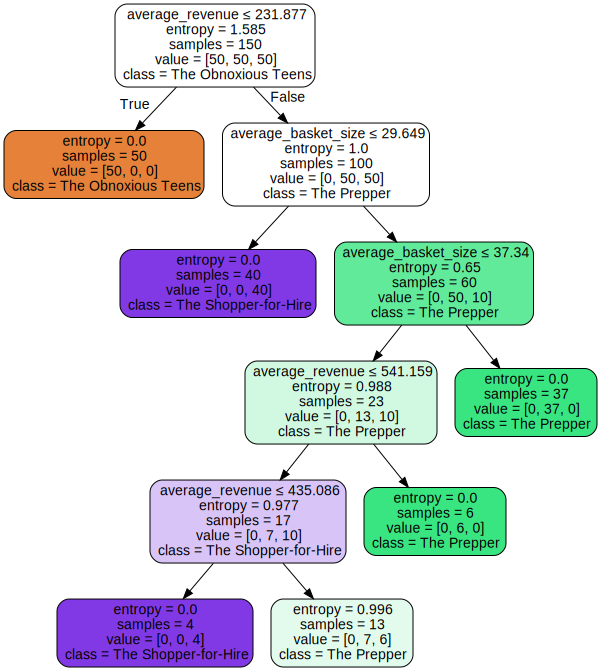

In [9]:
dot_data = sklearn.tree.export_graphviz(
    tree,
    out_file=None,
    feature_names=features,
    class_names=target_names,
    filled=True,
    rounded=True,
    special_characters=True,
)
graphviz.Source(dot_data)

<br> 

## Background

### Information gain ($IG$)

We'll split a node if information gain is larger than 0:

$
\quad {\displaystyle IG(\mathcal{D}_{parent}, \mathcal{D}_{left}, \mathcal{D}_{right}) = 
    H(\mathcal{D}_{parent}) - \frac{N_{left}}{N_{parent}} H(\mathcal{D}_{left}) - \frac{N_{right}}{N_{parent}} H(\mathcal{D}_{right})}
$

- $IG$: Information Gain
- $N_{parent}$: number of samples in the parent node
- $N_{left}$: number of samples in the left child node
- $N_{right}$: number of samples in the right child node
- $H$: Shannon entropy
- $\mathcal{D}_{parent}, \mathcal{D}_{left}, \mathcal{D}_{right}$: data sets (parent and child nodes)

### Shannon entropy $H$
Entropy $H$ is defined as 

$
\quad E = - \displaystyle\sum_i p_i \log_2 p_i
$

### Minimum Impurity Decrease 

- Decide when to stop splitting nodes (in addition to pure nodes)
- Node will be split of this split induces a decrease of the impurity greater (or equal) to MID
- MID functions as a threshold

$
{\displaystyle
\quad MID = \frac{N_{parent}}{N_{total}} \left[ H(\mathcal{D}_{parent}) - \frac{N_{left}}{N_{parent}} H(\mathcal{D}_{left}) - \frac{N_{right}}{N_{parent}} H(\mathcal{D}_{right}) \right]
}
$

### Impurity measures

#### Entropy

With proportion $p(j|t)$ of samples in class $j$ at node $t$:

$
\quad {\displaystyle H(t) = - \sum_{j=1}^k p(j|t) \log_2 p(j|t)}
$

Optimal entropy is 0 when all samples at a node belong to the same class

In [10]:
def entropy(p):
    return -p * np.log2(p) - (1 - p) * np.log2((1 - p))

#### Gini Index

$
\quad {\displaystyle G(t) = 1 - \sum_{j=1}^k \big(p(j|t)\big)^2}
$

Minimized when all samples at a node belong to the same class. Maximal value for $p(j|t) = \frac 1 k$.

In [11]:
def gini(p):
    return 1 - np.power(p, 2) - np.power((1 - p), 2)

#### Misclassification error

$
\quad {\displaystyle MC(t) = 1 - \max_k p(j|t)}
$

In [12]:
def error(p):
    return 1 - np.max([p, 1 - p], axis=0)

#### Comparison

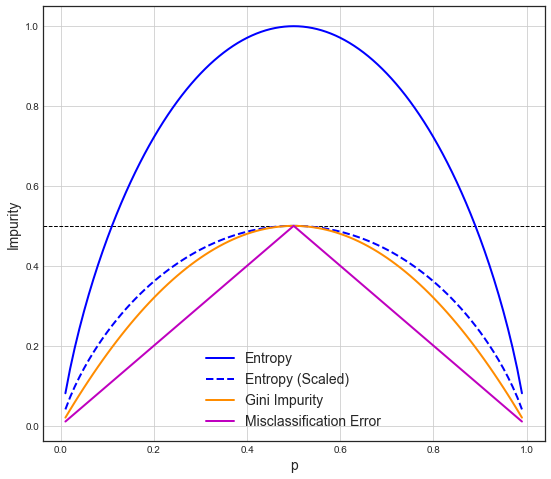

In [13]:
x = np.arange(0.01, 1.0, 0.01)

plt.figure(figsize=(9, 8))
plt.plot(x, entropy(x), linewidth=2, label="Entropy", c="b")
plt.plot(
    x, entropy(x) / 2, linewidth=2, label="Entropy (Scaled)", c="b", linestyle="--"
)
plt.plot(x, gini(x), linewidth=2, label="Gini Impurity", c="darkorange")
plt.plot(x, error(x), linewidth=2, label="Misclassification Error", c="m")

plt.legend(
    loc="lower center",
    ncol=1,
    fontsize=14,
)

plt.axhline(y=0.5, linestyle="--", c="k", zorder=1, linewidth=1)
plt.xlabel("p", fontsize=14)
plt.ylabel("Impurity", fontsize=14)
plt.show()

## Some first steps for building our own tree

In [14]:
features

['average_revenue',
 'average_basket_size',
 'fraction_canned_food',
 'fraction_national_brands']

### Let's look at a single feature

In [15]:
values = X[:, 0]
unique_values = np.sort(np.unique(values))

#### All possible cutoff values

In [16]:
cutoffs = (unique_values[:-1] + unique_values[1:]) / 2

In [17]:
for i, cutoff in enumerate(cutoffs):
    i, cutoff

In [18]:
i = 49
cutoff = cutoffs[i]
cutoff

231.87727039349355

#### Implement split based on feature

In [19]:
yhat = X[:, 0] <= cutoff

In [20]:
yhat

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

#### Entropy: Parent node

In [21]:
def compute_entropy(y):
    # number of samples
    n = len(y)
    # unique classes in `y_class`
    classes = set(y)

    # compute number of observations in each class
    n_c = np.zeros(len(classes))
    # compute probability for a sample to be in class
    p_c = np.zeros(len(classes))
    # compute entropy for each class
    e_c = np.zeros(len(classes))

    # computation
    for i, c in enumerate(classes):
        n_c[i] = np.sum(y == c)
        p_c[i] = n_c[i] / n
        e_c[i] = -p_c[i] * np.log2(p_c[i])
    assert n == sum(n_c)

    # total entropy
    e_p = np.sum(e_c)

    # return
    return e_p, n

In [22]:
e_p, n_p = compute_entropy(y)
e_p, n_p

(1.584962500721156, 150)

#### Entropy: Left child node

In [23]:
yhat

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [24]:
y[yhat]

array(['The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious Teens',
       'The Obnoxious Teens', 'The Obnoxious T

In [25]:
e_cl, n_cl = compute_entropy(y[yhat])
e_cl, n_cl

(0.0, 50)

#### Entropy: Right child node

In [26]:
e_cr, n_cr = compute_entropy(y[~yhat])
e_cr, n_cr

(1.0, 100)

#### Derive information gain

In [27]:
entropy_before = e_p  # parent node
entropy_after = n_cl / n_p * e_cl + n_cr / n_p * e_cr  # children nodes
entropy_before, entropy_after

(1.584962500721156, 0.6666666666666666)

In [28]:
entropy_before - entropy_after

0.9182958340544894

## Reminder: Training algorithm

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/trees-stopping.png" width="800px">

## Manual implementation: Our decision tree class

In [29]:
class DecisionTree:
    def __init__(
        self, feature_names, class_names, class_values, max_depth=5, eps=1e-8, verbose=0
    ):
        self.feature_names = feature_names
        self.class_names = class_names
        self.class_values = class_values

        self.max_depth = max_depth
        self.eps = eps  # break ties in information gain
        self.verbose = verbose

    def fit(self, X, y, depth, seeds):
        """
        Tree builder. This is a recursive function. Break for pure nodes or when max tree depth is reached.
        """

        # all `y` belong to the same class (pure node) -> terminate
        if len(np.unique(y)) == 1:
            return self._final_node(y)

        # reached `max_depth` -> terminate
        elif depth >= self.max_depth:
            return self._final_node(y)

        # add splits
        else:

            if depth < len(seeds):
                np.random.seed(seeds[depth])

            # find one split given an information gain
            column_chosen, cutoff_chosen, split_chosen, ig_chosen = self._find_split(
                X, y
            )
            node = {
                "entropy": float(round(self._entropy(y), 4)),
                "column": int(column_chosen),
                "cutoff": float(np.round(cutoff_chosen, 4)),
                "table": self._table(y),
                "split": f"{self.feature_names[column_chosen]} <= {cutoff_chosen:.4f}",
            }
            # generate new child trees
            node["-left"] = self.fit(
                X[split_chosen, :], y[split_chosen], depth + 1, seeds
            )
            node["-right"] = self.fit(
                X[~split_chosen, :], y[~split_chosen], depth + 1, seeds
            )

            self.fitted_tree = node

        return node

    def predict(self, X):
        """
        Walk through tree for new data samples.
        """
        predictions = np.zeros(len(X), dtype=np.int)
        for i, xi in enumerate(X):  # for each row in test data
            node = self.fitted_tree
            while node.get("cutoff"):
                if xi[node["column"]] <= node["cutoff"]:
                    node = node["-left"]
                else:
                    node = node["-right"]
            else:
                predictions[i] = node.get("value")
        return predictions

    def _find_split(self, X, y):
        """
        Determine whether to split a parent node and which feature/cutoff to use.
        """
        scores = []

        # loop over features
        for c in range(X.shape[1]):

            values = X[:, c]

            # loop over possible cutoffs
            unique_values = np.sort(np.unique(values))
            cutoffs = (unique_values[:-1] + unique_values[1:]) / 2
            for i, cutoff in enumerate(cutoffs):
                # split
                yhat = yhat = X[:, c] <= cutoff

                # entropy calculation
                entropy_parent = self._entropy(y)
                entropy_child_left = self._entropy(y[yhat])
                entropy_child_right = self._entropy(y[~yhat])

                # information gain
                information_gain = (
                    entropy_parent
                    - np.mean(yhat) * entropy_child_left
                    - np.mean(~yhat) * entropy_child_right
                )

                # save and log
                scores.append(
                    [
                        c,
                        cutoff,
                        len(yhat),
                        sum(yhat),
                        sum(~yhat),
                        information_gain,
                        entropy_parent,
                    ]
                )
                self._log(
                    f"col={c} | cutoff={cutoff:.2f} | gain={information_gain:.8f} | ent={entropy_parent:.4f}"
                )

        scores = pd.DataFrame(
            scores, columns=["column", "cutoff", "np", "ncl", "ncr", "ig", "ep"]
        )
        # break ties
        scores["ig"] += np.random.uniform(-self.eps, self.eps, scores.shape[0])
        #
        scores = scores.sort_values("ig", ascending=False)

        column_chosen = scores["column"].values[0]
        cutoff_chosen = scores["cutoff"].values[0]
        split_chosen = X[:, column_chosen] <= cutoff_chosen
        ig_chosen = scores["ig"].values[0]
        ig_all = scores["ig"].values
        return column_chosen, cutoff_chosen, split_chosen, ig_chosen  # , ig_all

    def _final_node(self, y):
        return {
            "entropy": float(round(self._entropy(y), 4)),
            "table": self._table(y),
            "value": self._mode(y),
        }

    def _table(self, y):
        return " | ".join([f"{yi}: {np.sum(y==yi)}" for yi in self.class_values])

    def _log(self, x):
        if self.verbose > 0:
            print(x)

    @staticmethod
    def _entropy(y):
        """
        Entropy calculation.
        """
        n = len(y)
        classes = set(y)
        n_c = np.zeros(len(classes))
        p_c = np.zeros(len(classes))
        e_c = np.zeros(len(classes))
        for i, c in enumerate(classes):
            n_c[i] = np.sum(y == c)
            p_c[i] = n_c[i] / n
            e_c[i] = -p_c[i] * np.log2(p_c[i])
        return np.sum(e_c)

    @staticmethod
    def _mode(x):
        """
        Majority vote with tie breaker.
        """
        values, counts = np.unique(x, return_counts=True)
        return int(np.random.choice(values[counts == np.max(counts)]))

### Fit

In [30]:
map_target_names = {
    "The Obnoxious Teens": 0,
    "The Prepper": 1,
    "The Shopper-for-Hire": 2,
}

In [31]:
y_bin = np.array([map_target_names[yi] for yi in y])

In [32]:
decision_tree = DecisionTree(
    feature_names=features,
    class_names=target_names,
    class_values=set(map_target_names.values()),
)
assert set(y_bin) == set(range(len(target_names)))

res = decision_tree.fit(X, y_bin, 0, seeds=[19])

### Inspect results

This is not pretty, but clearly illustrates the key insihgts :)

In [33]:
features

['average_revenue',
 'average_basket_size',
 'fraction_canned_food',
 'fraction_national_brands']

In [34]:
print(yaml.dump(decision_tree.fitted_tree, indent=4, sort_keys=False))

entropy: 1.585
column: 0
cutoff: 231.8773
table: '0: 50 | 1: 50 | 2: 50'
split: average_revenue <= 231.8773
-left:
    entropy: 0.0
    table: '0: 50 | 1: 0 | 2: 0'
    value: 0
-right:
    entropy: 1.0
    column: 1
    cutoff: 29.6488
    table: '0: 0 | 1: 50 | 2: 50'
    split: average_basket_size <= 29.6488
    -left:
        entropy: 0.0
        table: '0: 0 | 1: 0 | 2: 40'
        value: 2
    -right:
        entropy: 0.65
        column: 1
        cutoff: 37.3401
        table: '0: 0 | 1: 50 | 2: 10'
        split: average_basket_size <= 37.3401
        -left:
            entropy: 0.9877
            column: 0
            cutoff: 541.1592
            table: '0: 0 | 1: 13 | 2: 10'
            split: average_revenue <= 541.1592
            -left:
                entropy: 0.9774
                column: 0
                cutoff: 435.0863
                table: '0: 0 | 1: 7 | 2: 10'
                split: average_revenue <= 435.0863
                -left:
                    entropy: 

### Make predictions

In [35]:
decision_tree.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2])

## Tree explorer

Ensure that you have `ipywidgets` (and notebook/lab) extension installed:

    pip install ipywidgets
    jupyter nbextension enable --py widgetsnbextension
    jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [36]:
def plot_tree(**kwargs):

    decision_tree = sklearn.tree.DecisionTreeClassifier(random_state=123, **kwargs).fit(
        X, y
    )

    graph = graphviz.Source(
        sklearn.tree.export_graphviz(
            decision_tree,
            out_file=None,
            feature_names=features,
            class_names=target_names,
            rounded=True,
            filled=True,
        )
    )
    IPython.display.display(IPython.display.SVG(graph.pipe(format="svg")))

    return decision_tree

In [37]:
IPython.display.display(
    ipywidgets.interactive(
        plot_tree,
        criterion=["gini", "entropy"],
        max_depth=[2, 3, 4],
        max_features=(1, 4),
        min_samples_split=(2, 10),
        min_impurity_decrease=(0.0, 0.5),
        min_samples_leaf=(2, 20),
        max_leaf_nodes=(2, 20),
    )
)

interactive(children=(Dropdown(description='criterion', options=('gini', 'entropy'), value='gini'), Dropdown(d…

<br>
<br>
&mdash; <br>
Sebastian Gabel <br>
`Learning from Big Data`, Module 2, Lecture 06 <br>
2021/22 <br>